In [1]:
# Data Handling
import os
import pandas as pd
import numpy as np
from scipy.io import loadmat
from scipy import optimize
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import ecg_plot

# Machine Learning
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from scipy.optimize import fmin_powell
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence

# Keras Layers
from keras.preprocessing.sequence import pad_sequences
from keras.layers import (
    Input, Dense, Dropout, Activation, BatchNormalization, Add, Flatten, Embedding,
    Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional,
    concatenate, Lambda, Multiply, DepthwiseConv1D, MaxPooling1D
)
from keras.models import Sequential, Model, load_model

# Multi Processing
from joblib import Parallel, delayed
import multiprocessing

In [2]:
# Enable automatic reloading of modules before code execution
%load_ext autoreload

# Set autoreload to reload all modules automatically
%autoreload

# Reload the autoreload extension to apply changes
%reload_ext autoreload

In [3]:
pip install tensorflow-model-optimization

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\piyus\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Loading Data

In [3]:
def load_data(filename):
    """
    Load data from a .mat file along with its corresponding header (.hea) file.

    Args:
    - filename: Path to the .mat file containing data

    Returns:
    - data: NumPy array of float64 type containing the loaded data
    - header_data: List of strings containing the contents of the header file
    """
    # Load data from the .
    # \mat file
    mat_data = loadmat(filename)
    
    # Extract the 'val' field from the loaded data and convert it to a NumPy array of float64 type
    data = np.asarray(mat_data['val'], dtype=np.float64)
    
    # Generate the corresponding .hea filename by replacing the '.mat' extension with '.hea'
    header_filename = filename.replace('.mat', '.hea')
    
    # Read the contents of the .hea file
    with open(header_filename, 'r') as header_file:
        header_data = header_file.readlines()
    
    return data, header_data

ECG Plotting of a patient data

In [5]:
def plot_ecg(path):
    """
    Plot ECG data from a specified path.

    Args:
    - path: Path to the .mat file containing ECG data

    Returns:
    None
    """
    # Load ECG data from the specified path
    ecg_data, _ = load_data(path)
    
    # Plot the ECG data using the ecg_plot library
    # Divide the data by 1000 to convert it to millivolts
    ecg_plot.plot(ecg_data / 1000, sample_rate=500, title='')
    
    # Display the ECG plot
    ecg_plot.show()

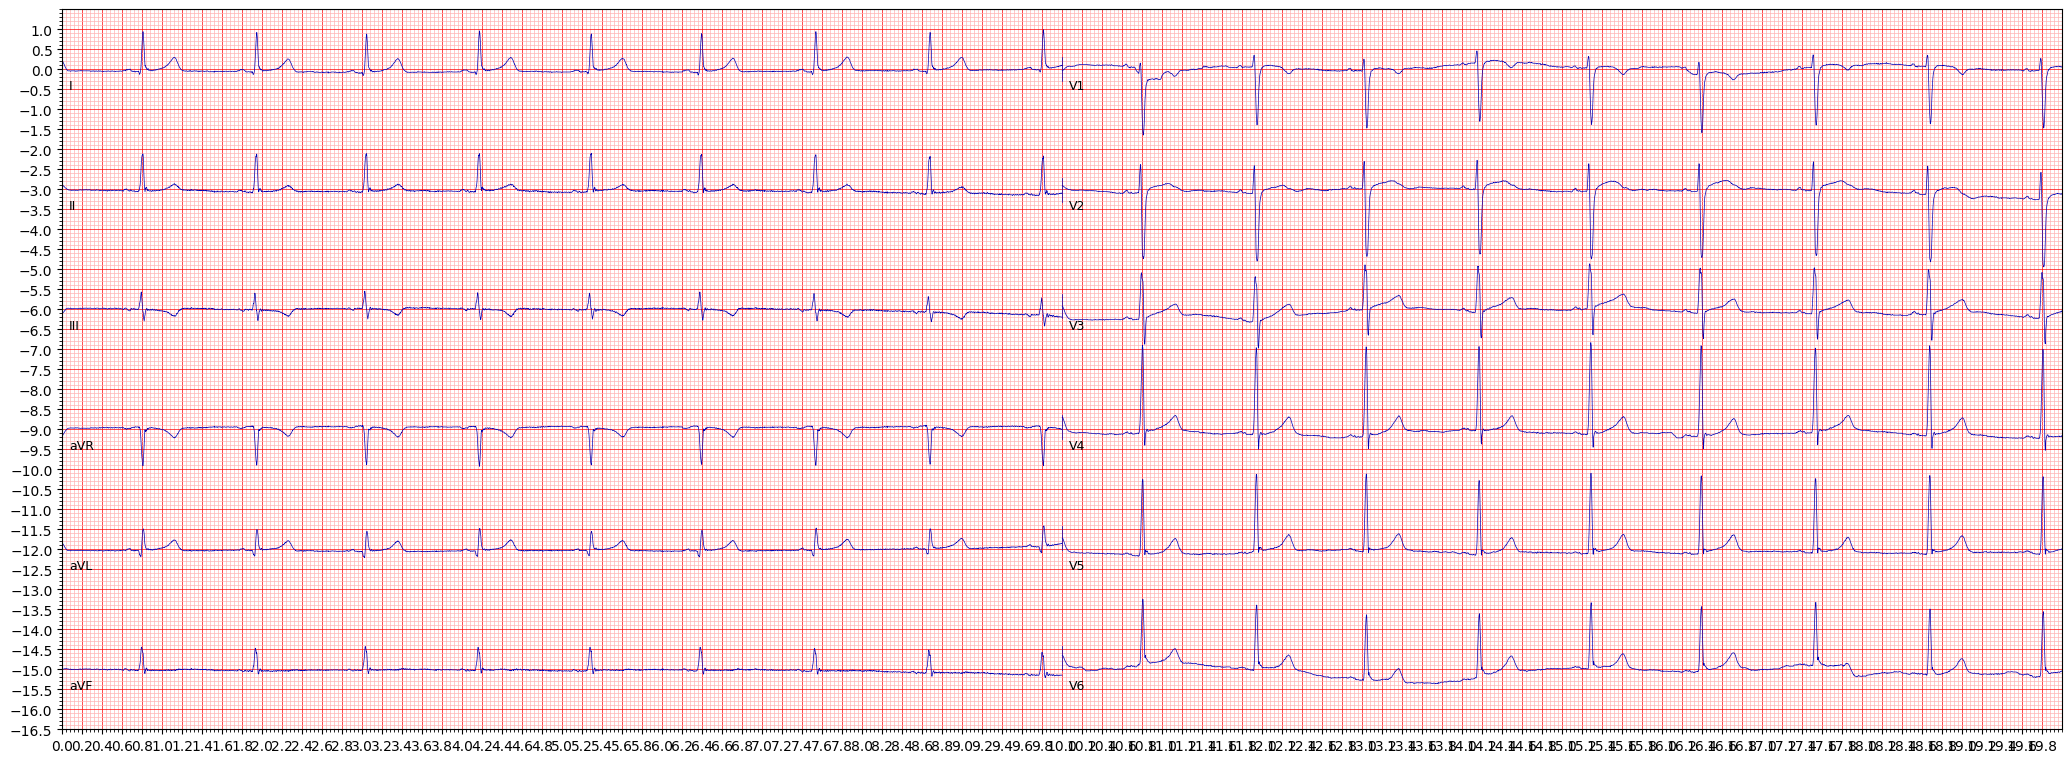

In [5]:
# Calling plot_ecg function
plot_ecg(r"data\WFDBRecords\01\010\JS00004.mat")

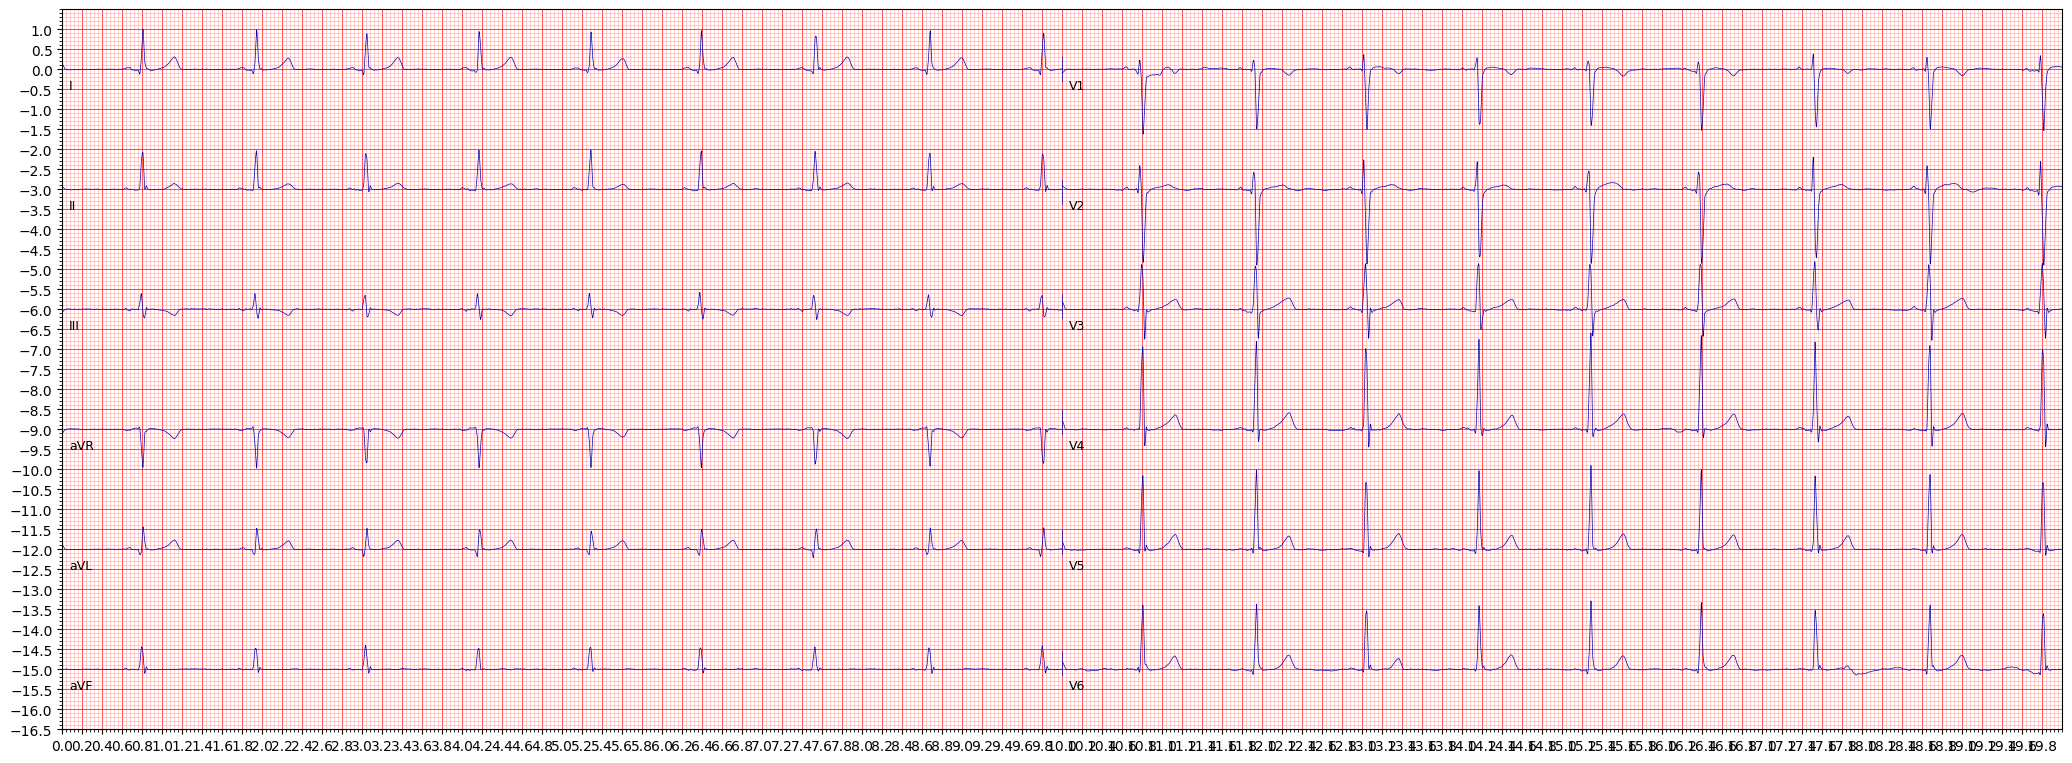

In [6]:
# Calling plot_ecg function
plot_ecg(r"denoised_data\JS00004.mat")

Importing Key Data

In [4]:
def process_file(filepath):
    """
    Process a single file to extract gender, age, labels, and ECG filename.

    Args:
    - filepath: Path to the .mat file

    Returns:
    - Tuple containing gender, age, labels, and filepath
    """
    print(f"Processing file: {filepath}")
    data, header_data = load_data(filepath)
    gender = header_data[14][6:-1]
    age = header_data[13][6:-1]
    label = header_data[15][5:-1]
    return gender, age, label, filepath

def import_key_data(path):
    """
    Import gender, age, labels, and ECG filenames from .mat files in a directory.

    Args:
    - path: Path to the directory containing .mat files

    Returns:
    Tuple containing lists of extracted data:
    - genders: List of gender information
    - ages: List of age information
    - labels: List of label information
    - ecg_filenames: List of ECG filepaths
    """
    ecg_filenames = []
    for subdir, dirs, files in sorted(os.walk(path)):
        for filename in files:
            filepath = os.path.join(subdir, filename)
            if filepath.endswith(".mat"):
                ecg_filenames.append(filepath)
    
    results = Parallel(n_jobs=-1)(delayed(process_file)(filepath) for filepath in ecg_filenames)
    
    genders, ages, labels, ecg_filenames = zip(*results)
    
    return list(genders), list(ages), list(labels), list(ecg_filenames)

In [5]:
# Import key data from the specified directory
gender, age, labels, ecg_filenames = import_key_data(r"denoised_data")

# Convert the list of filenames to a NumPy array
ecg_filenames = np.asarray(ecg_filenames)

Get Signal Length

In [6]:
def process_file(filepath):
    """
    Process a single file to extract the signal length and apply Z-score normalization.

    Args:
    - filepath: Path to the .mat file

    Returns:
    - Signal length (from header or calculated from normalized data)
    """
    # Load the data and header (assuming 'load_data' function exists)
    data, header_data = load_data(filepath)
    
    # Apply Z-score normalization to the signal
    data_normalized = (data - np.mean(data)) / np.std(data)
    
    # Option 1: Extract signal length from header (assuming signal length is in header_info[3])
    header_info = header_data[0].split()
    signal_length_from_header = int(header_info[3])  # Assuming this is the signal length
    
    # Option 2: Calculate length from the normalized data
    # signal_length_from_data = data_normalized.shape[1]  # Assuming data is a 2D array, where columns represent timepoints
    
    # Return signal length from header (or switch to length from data if preferred)
    return signal_length_from_header  # or return signal_length_from_data if you prefer to use t

def get_signal_lengths(path, title):
    """
    Get signal lengths from .mat files in a directory, apply Z-score normalization,
    and plot the distribution.

    Args:
    - path: Path to the directory containing .mat files
    - title: Title for the plot

    Returns:
    None
    """
    ecg_filenames = []
    
    # Walk through the directory to get all .mat file paths
    for subdir, dirs, files in sorted(os.walk(path)):
        for filename in files:
            filepath = os.path.join(subdir, filename)
            if filepath.endswith(".mat"):
                ecg_filenames.append(filepath)
    
    # Process all files in parallel and apply Z-score normalization in process_file
    signal_lengths = Parallel(n_jobs=-1)(delayed(process_file)(filepath) for filepath in ecg_filenames)
    
    # Convert signal lengths to a DataFrame
    signal_length_df = pd.DataFrame(signal_lengths, columns=["Length"])
    
    # Count occurrences of different signal lengths
    signal_count = signal_length_df["Length"].value_counts()
    
    # Plot the distribution of signal lengths
    plt.figure(figsize=(20, 10))
    plt.title(title, fontsize=36)
    sns.barplot(x=signal_count.index[:10], y=signal_count.values[:10])
    plt.xlabel('Signal Lengths')
    plt.ylabel('Count')
    plt.show()

In [9]:
# # Calling get_signal_lengths function
# get_signal_lengths("denoised_data", "Distribution of signal lengths of the ECGs")

Import Gender and Age

In [7]:
def clean_up_gender_data(gender):
    """
    Clean up gender data.

    Args:
    - gender: Array containing gender data

    Returns:
    - gender: Cleaned gender data as a NumPy array
    """
    
    # Convert gender to a NumPy array
    gender = np.asarray(gender)
    
    # Create a mapping for gender values to integers
    gender_map = {
        "Male": 0, "male": 0, "M": 0,
        "Female": 1, "female": 1, "F": 1,
        "NaN": 2, "Unknown": 2
    }
    
    # Apply the mapping to the gender array
    for key, value in gender_map.items():
        gender[np.where(gender == key)] = value
    
    # Convert the array to integers
    gender = gender.astype(int)
    
    return gender

In [10]:
def clean_up_age_data(age):
    """
    Clean up age data.

    Args:
    - age: Array containing age data

    Returns:
    - age_clean: Cleaned age data as a NumPy array
    """
    
    # Initialize a list to store cleaned age data
    age_clean = []
    
    # Iterate through each age value
    for a in age:
        try:
            # Attempt to convert the value to an integer
            age_clean.append(int(a))
        except ValueError:
            # If conversion fails (non-numeric value), replace with -1
            age_clean.append(-1)
    
    # Convert the list to a NumPy array
    return np.array(age_clean)

In [11]:
def import_gender_and_age(age, gender):
    """
    Import and clean gender and age data.

    Args:
    - age: Array containing age data
    - gender: Array containing gender data

    Returns:
    - age_clean: Cleaned age data
    - gender_binary: Cleaned binary gender data
    """
    
    # Clean up gender data
    gender_binary = clean_up_gender_data(gender)
    
    # Clean up age data
    age_clean = clean_up_age_data(age)
    
    # Print the shape of the cleaned gender and age data arrays
    print("gender data shape: {}".format(gender_binary.shape[0]))
    print("age data shape: {}".format(age_clean.shape[0]))
    
    # Return cleaned age and gender data
    return age_clean, gender_binary

In [12]:
# Calling import_gender_and_age
age, gender = import_gender_and_age(age, gender)

gender data shape: 25444
age data shape: 25444


Maling undefined class

In [13]:
def make_undefined_class(labels, df):
    """
    Replace specific labels with "undefined class".

    Args:
    - labels: Labels to be replaced
    - df: DataFrame containing the labels

    Returns:
    - df_labels: DataFrame with replaced labels
    """
    
    # Convert labels to a DataFrame
    df_labels = pd.DataFrame(labels)
    
    # Iterate through each row in the DataFrame 'df'
    for i in range(len(df.iloc[0:, 1])):
        # Replace specific labels with "undefined class"
        df_labels.replace(to_replace=str(df.iloc[i, 1]), inplace=True, value="undefined class", regex=True)
    
    # Return the DataFrame with replaced labels
    return df_labels

In [14]:
# Read the SNOMED-CT condition names from a CSV file
SNOMED = pd.read_csv(r"data\ConditionNames_SNOMED-CT.csv", sep=",")

# Apply the function to make undefined classes in the labels DataFrame
df_labels = make_undefined_class(labels, SNOMED)

One-Hot Encoding Labels

In [15]:
def onehot_encode(df_labels):
    """
    One-hot encode the labels.

    Args:
    - df_labels: DataFrame containing the labels

    Returns:
    - y: Encoded labels
    - classes: Corresponding classes
    """
    
    # Initialize MultiLabelBinarizer
    one_hot = MultiLabelBinarizer()
    
    # Perform one-hot encoding on the labels
    y = one_hot.fit_transform(df_labels[0].str.split(pat=','))

    # Print the encoded classes
    print("The classes we will look at are encoded as SNOMED CT codes:")
    print(one_hot.classes_)

    # Remove the last column as it corresponds to "undefined class"
    y = np.delete(y, -1, axis=1)

    # Print the number of classes
    print("classes: {}".format(y.shape[1]))

    # Return the encoded labels and the corresponding classes
    return y, one_hot.classes_[0:-1]

In [16]:
# Perform one-hot encoding on DataFrame labels
y , snomed_classes = onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '106068003' '164873001' '164890007' '164896001' '251120003'
 '251170000' '251187003' '251205003' '251223006' '29320008' '365413008'
 '418818005' '425856008' '426177001' '426183003' '426648003' '426783006'
 '427084000' '427172004' '445118002' '49578007' '50799005' '54329005'
 '55827005' '55930002' '57054005' '61277005' '61721007' '63593006'
 '6374002' '65778007' '67751000119106' '713426002' '713427006' '733534002'
 '81898007' 'Unknown']
classes: 37


Getting Acronyms for codes

In [17]:
# Initialize an empty list to store full names
snomed_abbr = []

# Filter y and snomed_classes to remove codes not found in SNOMED DataFrame
valid_codes = set(SNOMED["Snomed_CT"].astype(str))
filtered_snomed_classes = []
filtered_y = []

# Iterate over each code in snomed_classes
for i, code in enumerate(snomed_classes):
    # Check if the code is in the SNOMED DataFrame
    if code in valid_codes:
        # Append the code to the filtered list
        filtered_snomed_classes.append(code)
        
        # Retrieve the full name corresponding to the code and append it to snomed_abbr
        snomed_abbr.append(SNOMED.loc[SNOMED["Snomed_CT"].astype(str) == code, "Full Name"].values[0])
    else:
        # Print a message if the code is not found in the SNOMED DataFrame
        print(f"Code {code} not found in SNOMED DataFrame")

Code 10370003 not found in SNOMED DataFrame
Code 106068003 not found in SNOMED DataFrame
Code 164896001 not found in SNOMED DataFrame
Code 251120003 not found in SNOMED DataFrame
Code 251170000 not found in SNOMED DataFrame
Code 251187003 not found in SNOMED DataFrame
Code 251205003 not found in SNOMED DataFrame
Code 251223006 not found in SNOMED DataFrame
Code 29320008 not found in SNOMED DataFrame
Code 365413008 not found in SNOMED DataFrame
Code 418818005 not found in SNOMED DataFrame
Code 425856008 not found in SNOMED DataFrame
Code 426183003 not found in SNOMED DataFrame
Code 426648003 not found in SNOMED DataFrame
Code 427172004 not found in SNOMED DataFrame
Code 445118002 not found in SNOMED DataFrame
Code 49578007 not found in SNOMED DataFrame
Code 50799005 not found in SNOMED DataFrame
Code 54329005 not found in SNOMED DataFrame
Code 55827005 not found in SNOMED DataFrame
Code 55930002 not found in SNOMED DataFrame
Code 57054005 not found in SNOMED DataFrame
Code 61277005 not 

In [18]:
# Convert filtered_snomed_classes and snomed_abbr to numpy arrays
filtered_snomed_classes = np.asarray(filtered_snomed_classes)

# Filter y to include only the columns corresponding to codes found in the SNOMED DataFrame
filtered_y = y[:, [i for i, code in enumerate(snomed_classes) if code in valid_codes]]

In [19]:
# Print the content and shape of snomed_abbr
print("snomed_abbr:", snomed_abbr)
print("snomed_abbr shape:", np.array(snomed_abbr).shape)

# Print the shape of filtered_snomed_classes and filtered_y
print("filtered_snomed_classes shape:", filtered_snomed_classes.shape)
print("filtered_y shape:", filtered_y.shape)

snomed_abbr: ['left ventricle hypertrophy', 'Atrial Flutter', 'Sinus Bradycardia', 'Sinus Rhythm', 'Sinus Tachycardia']
snomed_abbr shape: (5,)
filtered_snomed_classes shape: (5,)
filtered_y shape: (25444, 5)


In [20]:
abbr = snomed_abbr

In [21]:
abbr

['left ventricle hypertrophy',
 'Atrial Flutter',
 'Sinus Bradycardia',
 'Sinus Rhythm',
 'Sinus Tachycardia']

In [22]:
# Assign the filtered versions of snomed_classes and filtered_y back to their original variables
snomed_classes = filtered_snomed_classes
y = filtered_y

In [21]:
# Print snomed_classes
print("snomed_classes:")
print(snomed_classes)

# Print SNOMED CT codes in SNOMED DataFrame
print("\nSNOMED CT codes in SNOMED DataFrame:")
print(SNOMED["Snomed_CT"].tolist())

snomed_classes:
['164873001' '164890007' '426177001' '426783006' '427084000']

SNOMED CT codes in SNOMED DataFrame:
[270492004, 195042002, 54016002, 28189009, 27885002, 251173003, 39732003, 284470004, 164917005, 47665007, 233917008, 251199005, 251198002, 428417006, 164942001, 698252002, 698252002, 426995002, 251164006, 164909002, 164909002, 164909002, 164873001, 251146004, 251148003, 251147008, 164865005, 164865005, 164865005, 164865005, 164865005, 164947007, 164912004, 111975006, 446358003, 59118001, 89792004, 429622005, 164930006, 428750005, 164931005, 164934002, 59931005, 164937009, 11157007, 75532003, 13640000, 17338001, 195060002, 251180001, 195101003, 74390002, 426177001, 426783006, 164889003, 427084000, 164890007, 427393009, 426761007, 713422000, 233896004, 233897008, 195101003]


In [24]:
def plot_classes(classes, scored_classes, y):
    """
    Plot the distribution of diagnoses.

    Args:
    - classes: List of classes
    - scored_classes: DataFrame containing scored classes
    - y: True labels

    Returns:
    - None
    """
    
    # Iterate through each class
    for j in range(len(classes)):
        # Iterate through each scored class
        for i in range(len(scored_classes.iloc[:, 1])):
            # Check if the scored class matches the current class
            if str(scored_classes.iloc[:, 1][i]) == classes[j]:
                # Replace the class with its corresponding label
                classes[j] = scored_classes.iloc[:, 0][i]

    # Plot the distribution of diagnoses
    plt.figure(figsize=(30, 20))
    plt.bar(x=classes, height=y.sum(axis=0))
    plt.title("Distribution of Diagnosis", color="black", fontsize=30)
    plt.tick_params(axis="both", colors="black")
    plt.xlabel("Diagnosis", color="black")
    plt.ylabel("Count", color="black")
    plt.xticks(rotation=90, fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig("fordeling.png")  # Save the plot as an image
    plt.show()

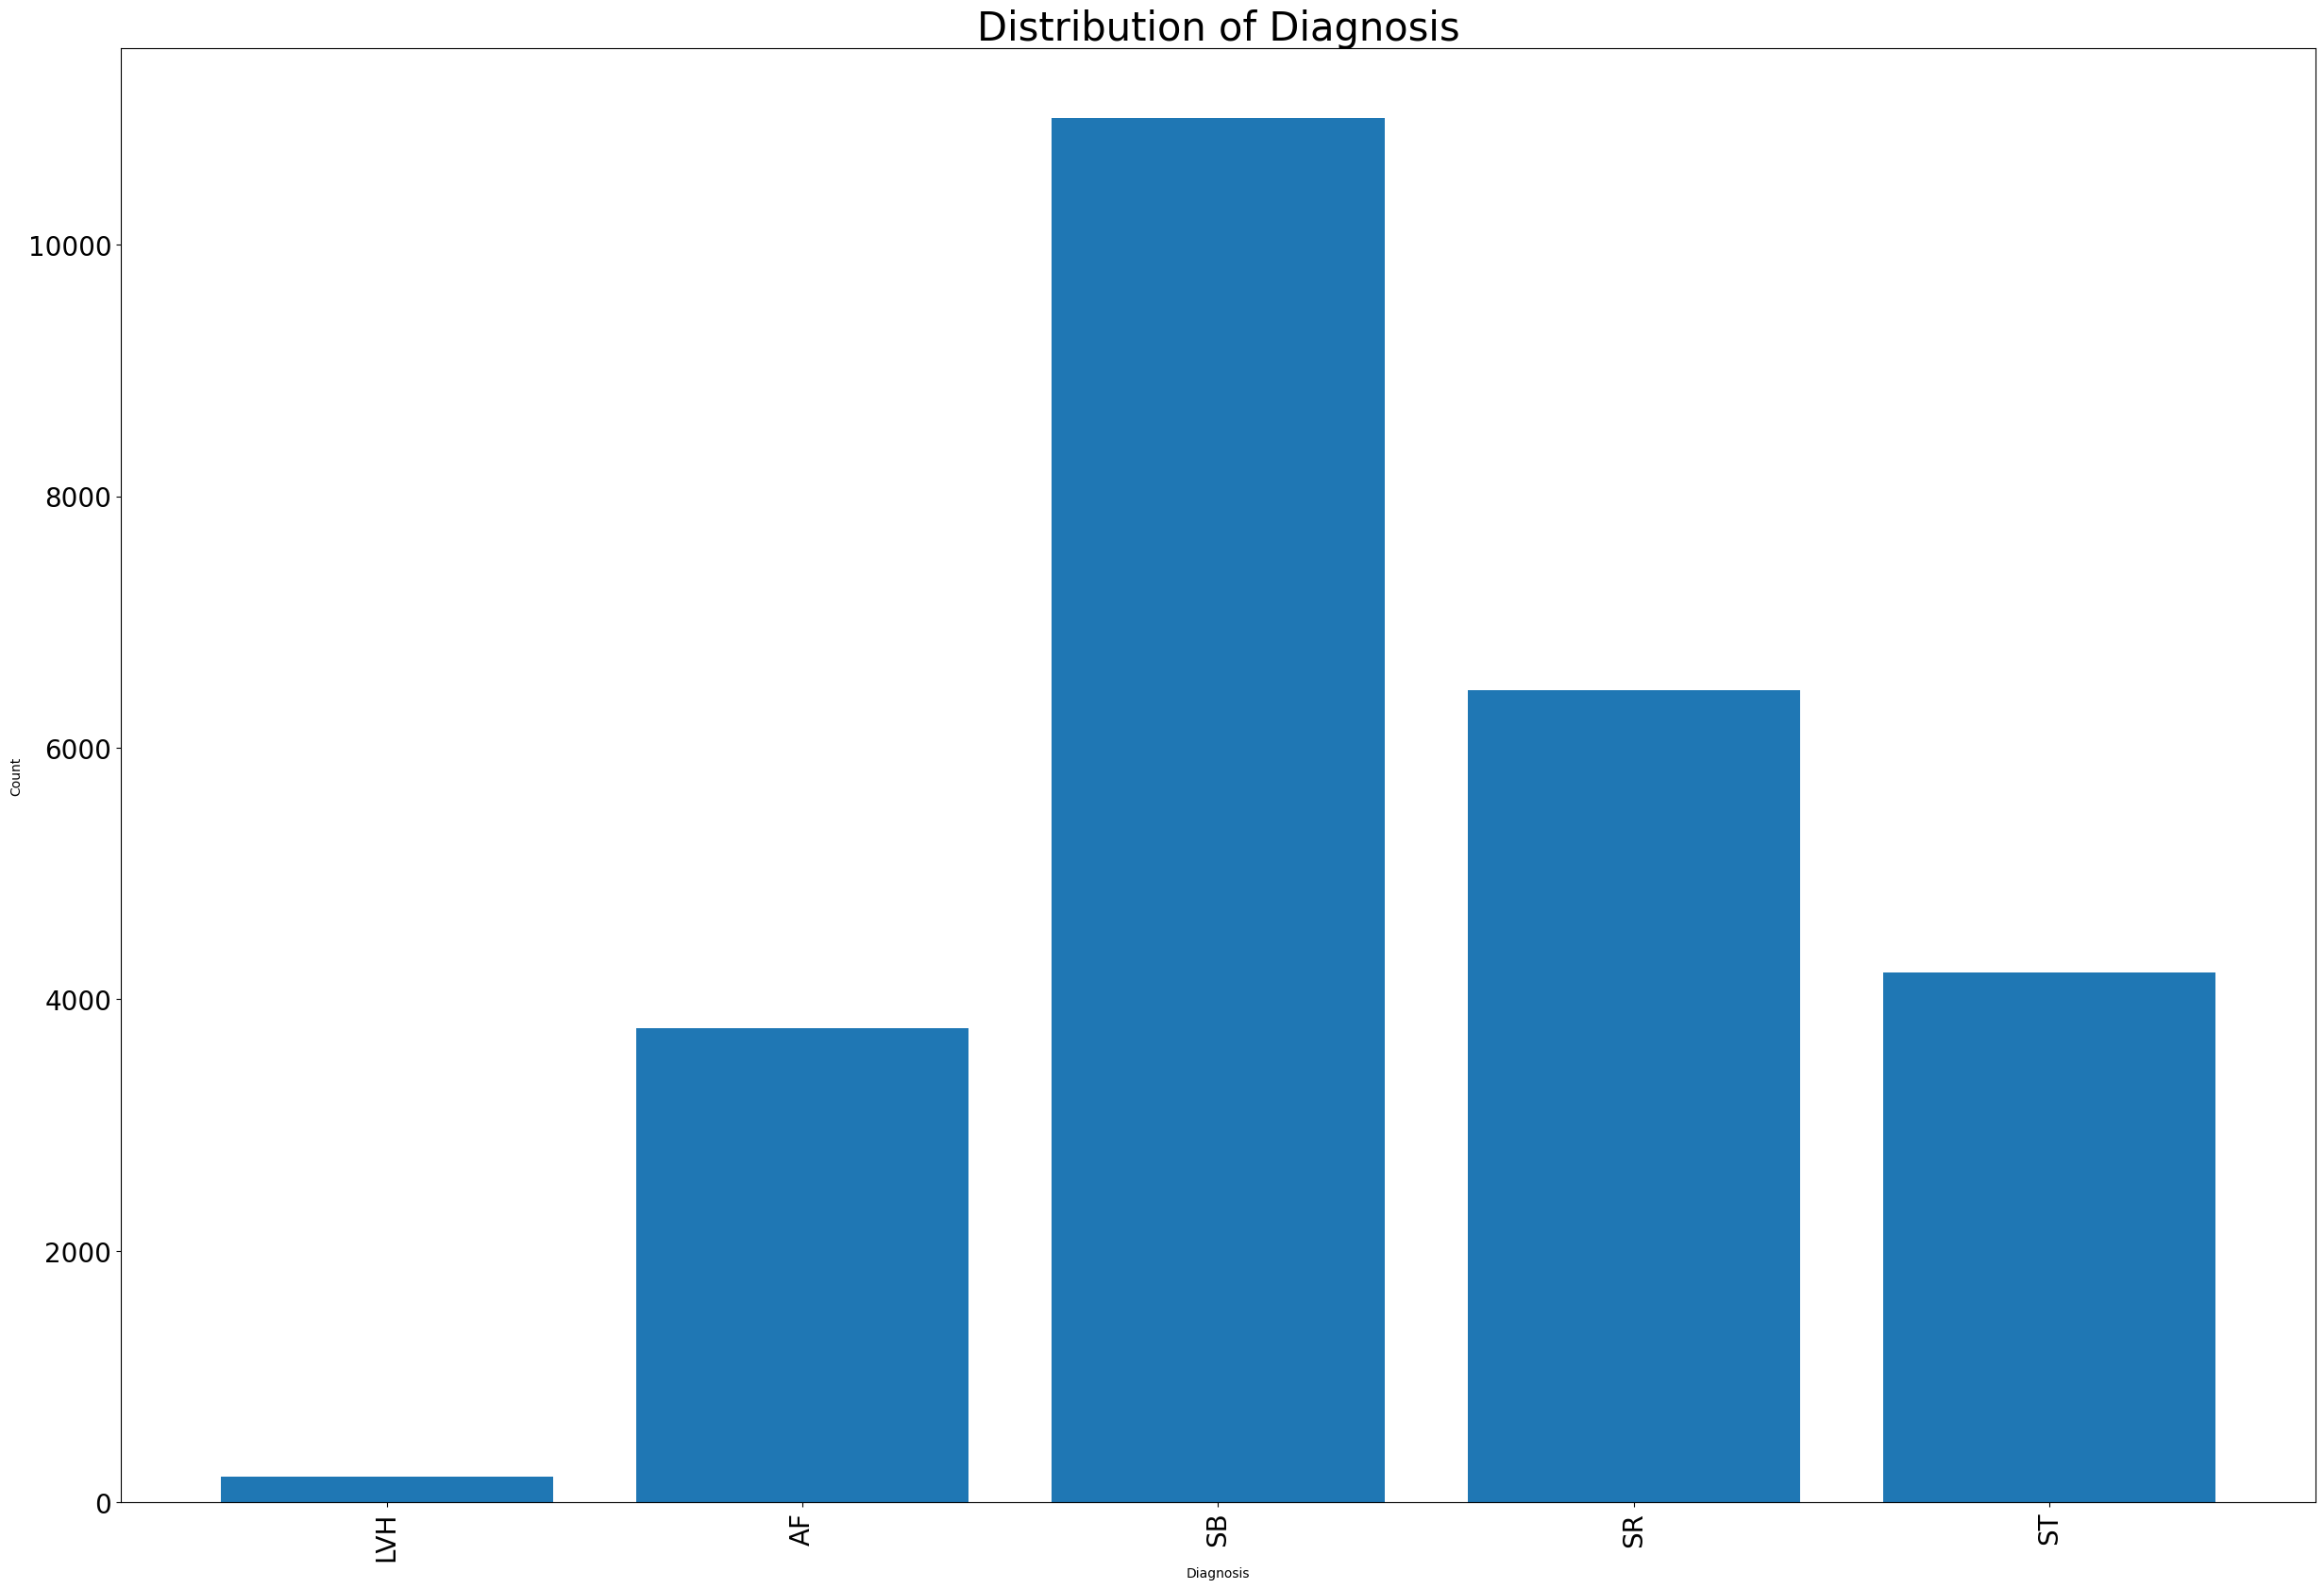

In [25]:
# plotting Distribution of Diagnosis graph
plot_classes(abbr, SNOMED,y)

Label Encoding

In [38]:
def get_labels_for_all_combinations(y):
    """
    Get labels for all combinations by converting each row of y into a string and joining them together.

    Args:
    - y: True labels

    Returns:
    - y_all_combinations: Numeric representations of combined labels
    """
    
    # Convert each row of y into a string and join them together
    y_strings = [''.join(str(label) for label in row) for row in y]
    
    # Use LabelEncoder to transform the combined labels into numeric representations
    y_all_combinations = LabelEncoder().fit_transform(y_strings)
    
    return y_all_combinations

In [39]:
# Convert multi-labels into single labels
y_all_comb = get_labels_for_all_combinations(y)

# Count the number of unique combinations
num_unique_combinations = len(np.unique(y_all_comb))

# Print the total number of unique combinations of diagnoses
print("Total number of unique combinations of diagnosis: {}".format(num_unique_combinations))


Total number of unique combinations of diagnosis: 15


Splitting the data

In [43]:
def split_data(labels, y_all_combo):
    """
    Split the data into 10 folds using StratifiedKFold while preserving the class distribution.

    Args:
    - labels: True labels
    - y_all_combo: Combined one-hot encoded labels

    Returns:
    - folds: List of tuples containing train and validation indices for each fold
    """
    
    # Use StratifiedKFold to split the data into 10 folds while preserving the class distribution
    folds = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(labels, y_all_combo))
    
    # Print the size of the training and validation splits for the first fold
    print("Training split: {}".format(len(folds[0][0])))
    print("Validation split: {}".format(len(folds[0][1])))
    
    # Return the folds
    return folds

In [44]:
# Call the split_data function to split the data into folds
folds = split_data(labels, y_all_comb)

Training split: 16962
Validation split: 8482


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Plotting all folds

In [45]:
def plot_all_folds(folds, y, onehot_enc, snomed_abbr):
    """
    Plot distribution of diagnoses for each fold.

    Args:
    - folds: List of tuples containing train and validation indices for each fold
    - y: One-hot encoded labels
    - onehot_enc: OneHotEncoder object
    - snomed_abbr: Array containing SNOMED abbreviation for each class

    Returns:
    - None
    """
    
    # Use the full names as x-axis labels
    X_axis_labels = abbr  
    
    # Create a new figure
    plt.figure(figsize=(20, 100))
    
    # Initialize subplot index
    h = 1
    
    # Iterate over each fold
    for i in range(len(folds)):
        # Plot distribution of diagnoses for the training set
        plt.subplot(10, 2, h)
        plt.subplots_adjust(hspace=1.0)
        plt.bar(x=X_axis_labels, height=y[folds[i][0]].sum(axis=0))
        plt.title("Distribution of Diagnosis - Training set - Fold {}".format(i+1), fontsize=20, color="black")
        plt.tick_params(axis="both", colors="black")
        plt.xticks(rotation=90, fontsize=10)
        plt.yticks(fontsize=10)
        plt.ylabel("Count", color="black")
        h = h + 1

        # Plot distribution of diagnoses for the validation set
        plt.subplot(10, 2, h)
        plt.subplots_adjust(hspace=1.0)
        plt.bar(x=X_axis_labels, height=y[folds[i][1]].sum(axis=0))
        plt.title("Distribution of Diagnosis - Validation set - Fold {}".format(i+1), fontsize=20, color="black")
        plt.tick_params(axis="both", colors="black")
        plt.ylabel("Count", color="black")
        plt.xticks(rotation=90, fontsize=10)
        plt.yticks(fontsize=10)
        h = h + 1

    # Adjust layout and save the plot as an image
    plt.tight_layout()
    plt.savefig("distribution_of_diagnosis.png")
    plt.show()

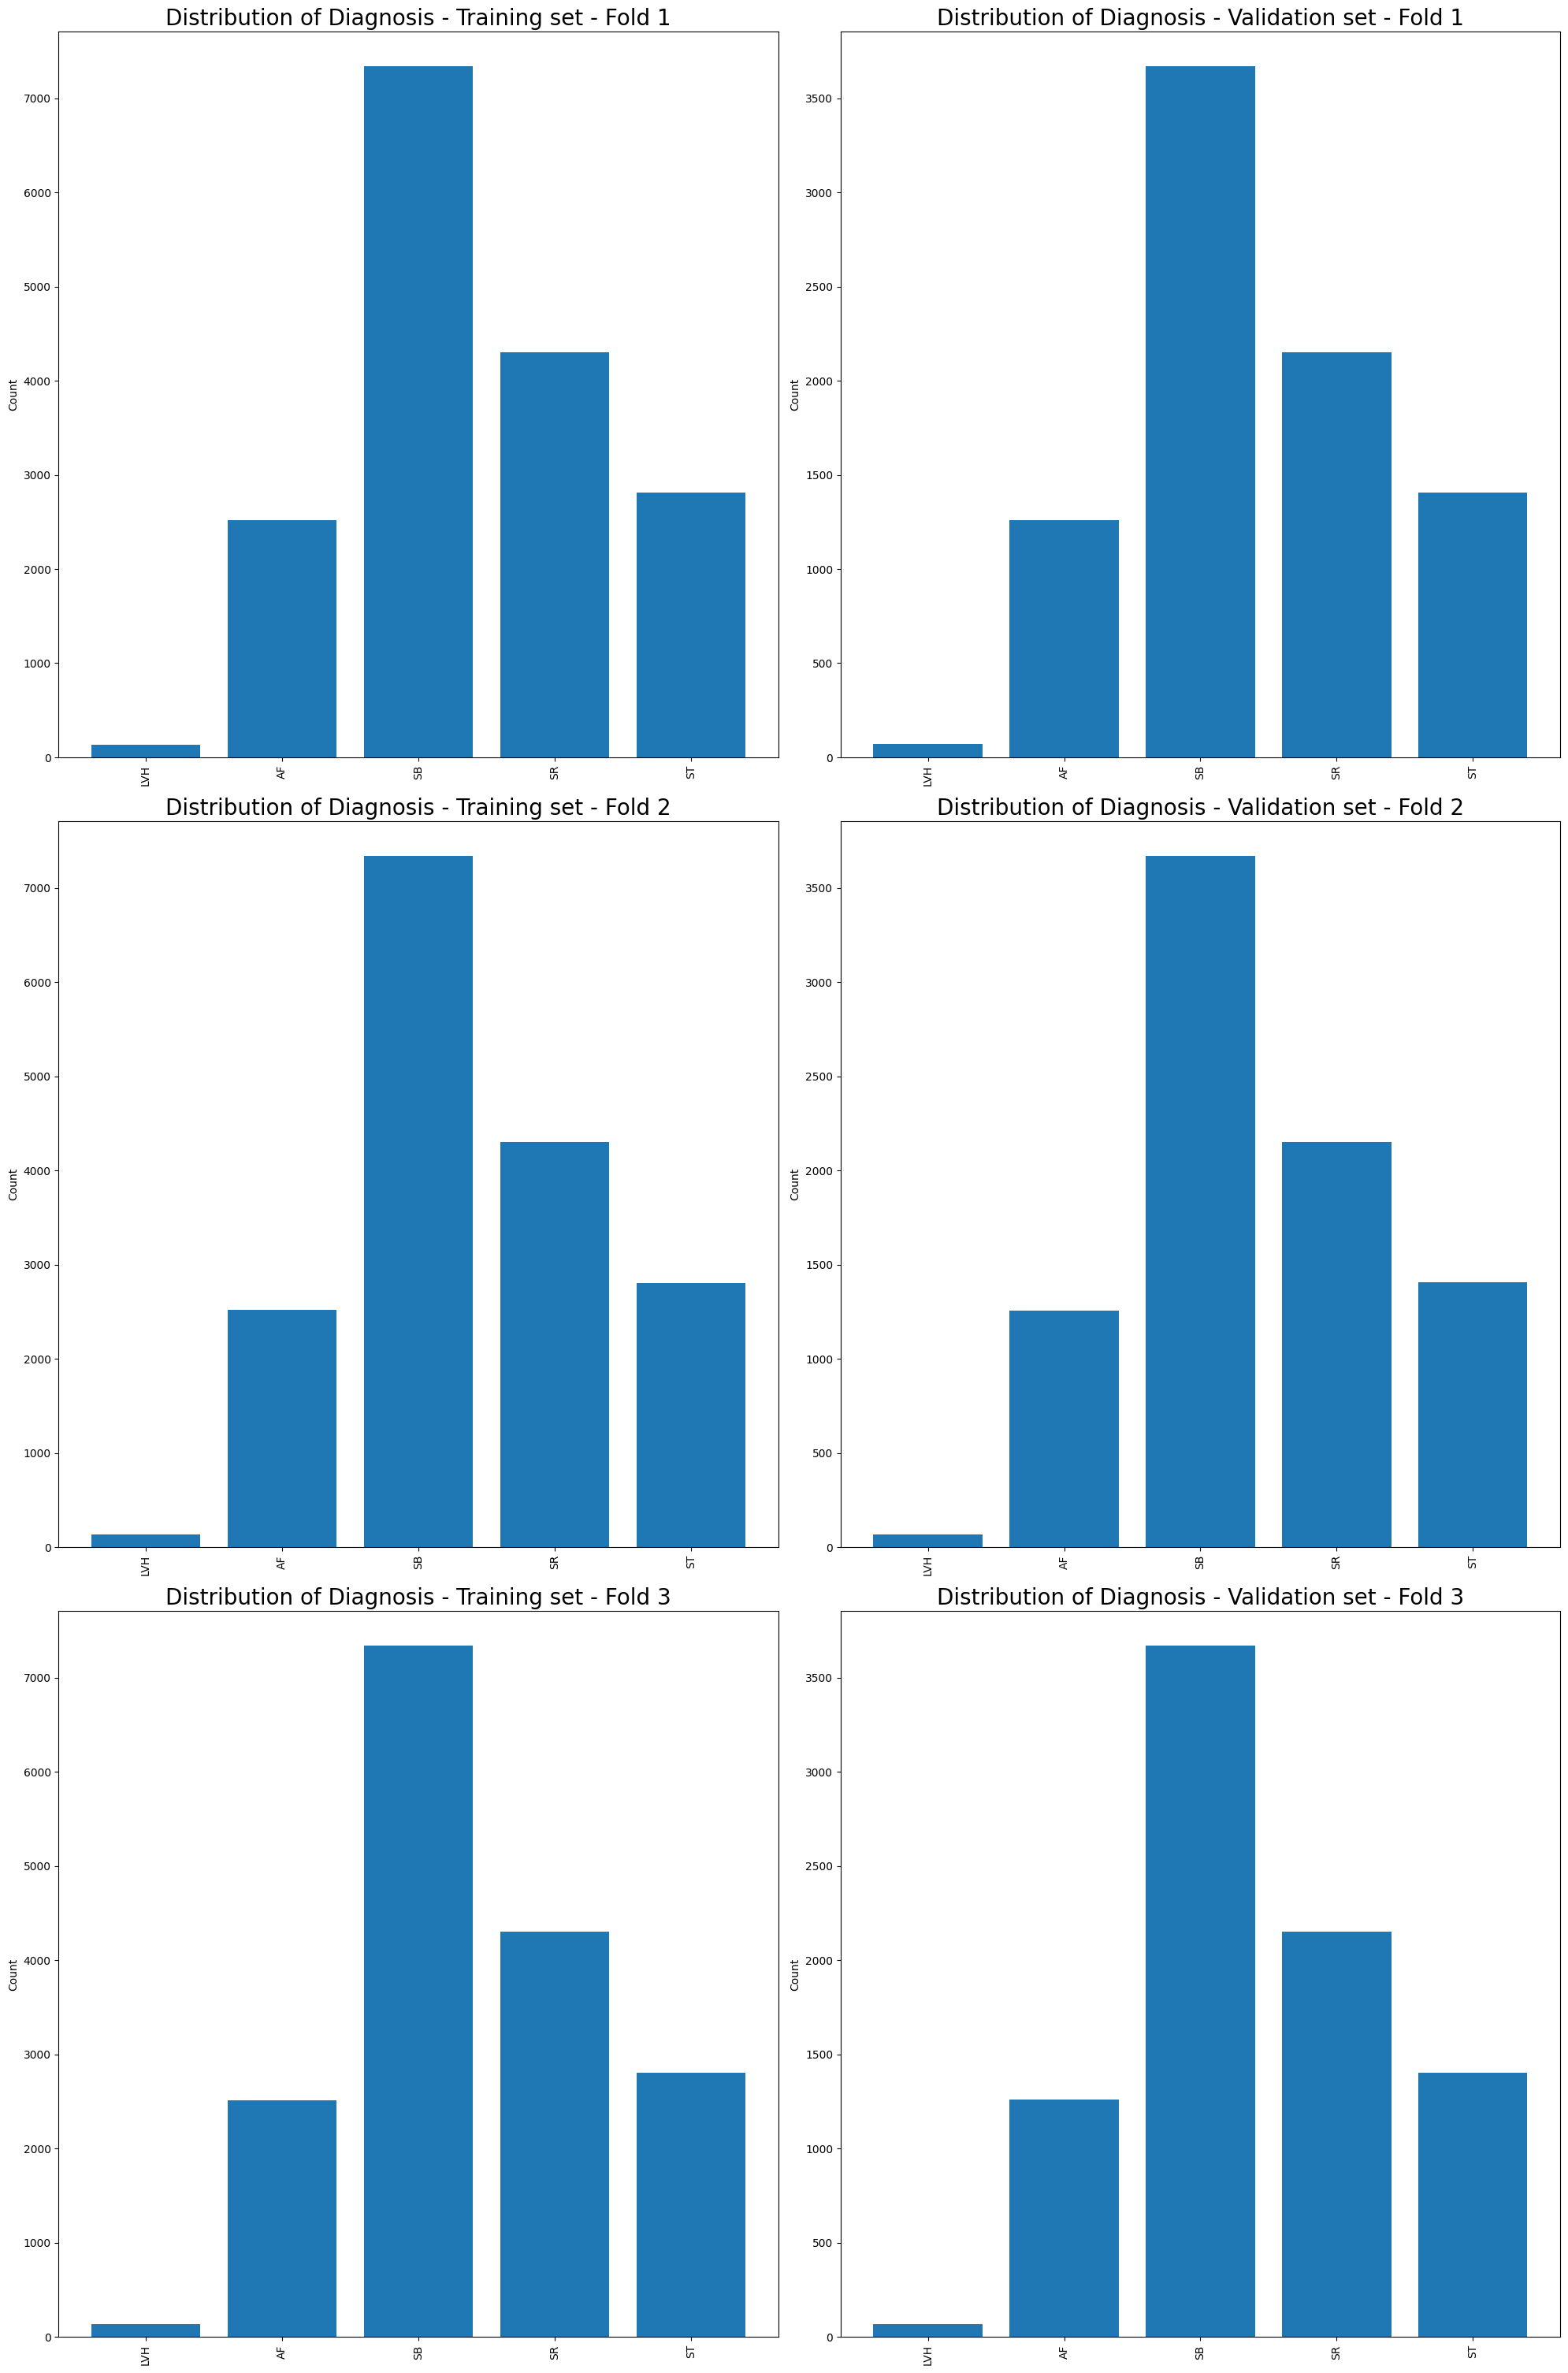

In [33]:
# Plotting all folds
plot_all_folds(folds, y, snomed_classes, abbr)

In [26]:
# Accessing the indices of the training set for the first fold
order_array = folds[0][0]

Model Creation

* Initializations

In [27]:
# ReduceLROnPlateau callback:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC',        # Metric to monitor for learning rate reduction
    factor=0.1,               # Factor by which the learning rate will be reduced
    patience=1,               # Number of epochs with no improvement before reducing learning rate
    verbose=1,                # Verbosity mode (0 or 1)
    mode='max',               # Mode for monitoring ('max' or 'min')
    min_delta=0.0001,         # Minimum change in the monitored quantity to qualify as an improvement
    cooldown=0,               # Number of epochs to wait before resuming normal operation after LR has been reduced
    min_lr=0                  # Lower bound on the learning rate
)

# EarlyStopping callback:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_AUC',        # Metric to monitor for early stopping
    mode='max',               # Mode for monitoring ('max' or 'min')
    verbose=1,                # Verbosity mode (0 or 1)
    patience=2                # Number of epochs with no improvement before stopping training
)

In [28]:
callbacks = [early_stop, reduce_lr]

1D CNN bilstm

In [29]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure the same data type
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)

        # Update true positives, false positives, and false negatives
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


In [38]:
from keras.regularizers import l2

def identity_block_1d(X, f, filters, l2_reg=0.001):
    """
    Implementation of the identity block for 1D CNN.

    Arguments:
    X -- input tensor
    f -- integer, specifying the shape of the middle CONV's window
    filters -- list of integers, defining the number of filters in the CONV layers
    l2_reg -- L2 regularization factor

    Returns:
    X -- output of the identity block
    """
    F1, F2, F3 = filters
    X_shortcut = X

    # First component of main path
    X = Conv1D(F1, 1, strides=1, padding='same', kernel_regularizer=l2(l2_reg))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv1D(F2, f, strides=1, padding='same', kernel_regularizer=l2(l2_reg))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv1D(F3, 1, strides=1, padding='same', kernel_regularizer=l2(l2_reg))(X)
    X = BatchNormalization()(X)

    # Add shortcut and pass through ReLU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block_1d(X, f, filters, s=2, l2_reg=0.001):
    """
    Implementation of the convolutional block for 1D CNN.

    Arguments:
    X -- input tensor
    f -- integer, specifying the shape of the middle CONV's window
    filters -- list of integers, defining the number of filters in the CONV layers
    s -- integer, specifying the stride
    l2_reg -- L2 regularization factor

    Returns:
    X -- output of the convolutional block
    """
    F1, F2, F3 = filters
    X_shortcut = X

    # First component of main path
    X = Conv1D(F1, 1, strides=s, padding='same', kernel_regularizer=l2(l2_reg))(X)
    X = Dropout(0.2)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv1D(F2, f, strides=1, padding='same', kernel_regularizer=l2(l2_reg))(X)
    X = Dropout(0.2)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv1D(F3, 1, strides=1, padding='same', kernel_regularizer=l2(l2_reg))(X)
    X = Dropout(0.2)(X)
    X = BatchNormalization()(X)

    # Shortcut path
    X_shortcut = Conv1D(F3, 1, strides=s, padding='same', kernel_regularizer=l2(l2_reg))(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)

    # Add shortcut to the main path and pass through ReLU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def CNN_BiLSTM(input_shape, l2_reg=0.001):
    # Input Layer
    X_input = Input(input_shape)
    
    # Stage 1
    X = Conv1D(64, 7, strides=2, kernel_regularizer=l2(l2_reg))(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(3, strides=2, padding='same')(X)
    X = Dropout(0.2)(X)

    # Stage 2
    X = convolutional_block_1d(X, f=3, filters=[64, 64, 256], s=1, l2_reg=l2_reg)
    X = Dropout(0.2)(X)
    X = identity_block_1d(X, 3, [64, 64, 256], l2_reg=l2_reg)
    X = identity_block_1d(X, 3, [64, 64, 256], l2_reg=l2_reg)

    # Stage 3
    X = convolutional_block_1d(X, f=3, filters=[128, 128, 512], s=2, l2_reg=l2_reg)
    X = Dropout(0.2)(X)
    X = identity_block_1d(X, 3, [128, 128, 512], l2_reg=l2_reg)
    X = identity_block_1d(X, 3, [128, 128, 512], l2_reg=l2_reg)
    X = identity_block_1d(X, 3, [128, 128, 512], l2_reg=l2_reg)

    # Stage 4
    X = convolutional_block_1d(X, f=3, filters=[256, 256, 1024], s=2, l2_reg=l2_reg)
    X = Dropout(0.2)(X)
    X = identity_block_1d(X, 3, [256, 256, 1024], l2_reg=l2_reg)
    X = identity_block_1d(X, 3, [256, 256, 1024], l2_reg=l2_reg)
    X = identity_block_1d(X, 3, [256, 256, 1024], l2_reg=l2_reg)
    X = identity_block_1d(X, 3, [256, 256, 1024], l2_reg=l2_reg)

    # Stage 5
    X = convolutional_block_1d(X, f=3, filters=[512, 512, 2048], s=2, l2_reg=l2_reg)
    X = Dropout(0.2)(X)
    X = identity_block_1d(X, 3, [512, 512, 2048], l2_reg=l2_reg)
    X = identity_block_1d(X, 3, [512, 512, 2048], l2_reg=l2_reg)

    # Feed the output into Bidirectional LSTM
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
    
    # Add a second Bidirectional LSTM if necessary
    X = Bidirectional(LSTM(128))(X)  # Uncomment this for stacked LSTMs
    
    # Final Dense layer for classification or regression
    X = Dense(5, activation='sigmoid', kernel_regularizer=l2(l2_reg))(X)

    # Create the model
    model = Model(inputs=X_input, outputs=X, name='CNN_BiLSTM')

    return model

In [39]:
# Define the model
model = CNN_BiLSTM(input_shape=(5000, 12))

In [40]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
        tf.keras.metrics.Recall(name='Recall'),
        tf.keras.metrics.Precision(name='Precision'),
        tf.keras.metrics.AUC(
            num_thresholds=200,
            curve="ROC",
            summation_method="interpolation",
            name="AUC",
            multi_label=True,
        ),
        F1Score(name='F1_Score')  # Add custom F1 Score metric
    ]
)

RESTNet50

In [41]:
# def convolutional_block(X, f, filters, s = 2):
#     """
#     Implementation of the convolutional block as defined in Figure 4.

#     Arguments:
#     X -- input tensor of shape (m, n_H_prev, n_C_prev)
#     f -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main path
#     s -- Integer, specifying the stride to be used

#     Returns:
#     X -- output of the convolutional block, tensor of shape (m, n_H, n_C)
#     """
#     # Retrieve Filters
#     F1, F2, F3 = filters
    
#     # Save the input value
#     X_shortcut = X

#     # First component of main path
#     X = Conv1D(F1, 1, strides = s, padding = 'same')(X)
#     X = BatchNormalization()(X)
#     X = Activation('relu')(X)
    
#     # Second component of main path
#     X = Conv1D(F2, f, strides = 1, padding = 'same')(X)
#     X = BatchNormalization()(X)
#     X = Activation('relu')(X)
    
#     # Third component of main path
#     X = Conv1D(F3, 1, strides = 1, padding = 'same')(X)
#     X = BatchNormalization()(X)

#     # Shortcut path
#     X_shortcut = Conv1D(F3, 1, strides = s, padding = 'same')(X_shortcut)
#     X_shortcut = BatchNormalization()(X_shortcut)
    
#     # Final step: Add shortcut value to main path, and pass it through a RELU activation
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)
    
#     return X


In [42]:
# def identity_block(X, f, filters):
#     """
#     Implementation of the identity block as defined in Figure 4.

#     Arguments:
#     X -- input tensor of shape (m, n_H_prev, n_C_prev)
#     f -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main path

#     Returns:
#     X -- output of the identity block, tensor of shape (m, n_H, n_C)
#     """

#      # Retrieve Filters
#     F1, F2, F3 = filters
    
#     # Save the input value. You'll need this later to add back to the main path. 
#     X_shortcut = X
    
#     # First component of main path
#     X = Conv1D(filters = F1, kernel_size = 1, strides = 1, padding = 'same')(X)
#     X = BatchNormalization()(X)
#     X = Activation('relu')(X)
    
#     # Second component of main path
#     X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'same')(X)
#     X = BatchNormalization()(X)
#     X = Activation('relu')(X)

#     # Third component of main path
#     X = Conv1D(filters = F3, kernel_size = 1, strides = 1, padding = 'same')(X)
#     X = BatchNormalization()(X)
    
#     # Final step: Add shortcut value to main path, and pass it through a RELU activation
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)
    
#     return X

In [43]:
# def ResNet50(input_shape):
    
#     X_input=Input(input_shape)
    
#     X = ZeroPadding1D(3)(X_input)
    
#     X = Conv1D(filters = 64, kernel_size = 7, padding = 'same')(X)
#     X = BatchNormalization()(X)
#     X = Activation('relu')(X)
#     X = MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    
#     X = Conv1D(filters = 64, kernel_size = 1, padding = 'same')(X)
#     X = BatchNormalization()(X)
#     X = Activation('relu')(X)
    
#     X = MaxPool1D(pool_size=7, strides=2, padding='same')(X)
    
#     X = GlobalAveragePooling1D()(X)
#     X = Dense(51,activation='sigmoid')(X)
    
    
#     X_input = Input(input_shape)

#     X = ZeroPadding1D(3)(X_input)
    
#     X = Conv1D(64, 7, strides = 2)(X)
#     X = BatchNormalization()(X)
#     X = Activation('relu')(X)
#     X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

#     X = convolutional_block(X, f = 3, filters = [32, 32, 64], s = 1)
#     X = identity_block(X, 3, [32, 32, 64])
#     X = identity_block(X, 3, [32, 32, 64])

#     X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
#     X = identity_block(X, 3, [64, 64, 256])
#     X = identity_block(X, 3, [64, 64, 256])

#     X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
#     X = identity_block(X, 3, [128,128,512])
#     X = identity_block(X, 3, [128,128,512])
#     X = identity_block(X, 3, [128,128,512])

#     X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
#     X = identity_block(X, 3, [256, 256, 1024])
#     X = identity_block(X, 3, [256, 256, 1024])
#     X = identity_block(X, 3, [256, 256, 1024])
#     X = identity_block(X, 3, [256, 256, 1024])
#     X = identity_block(X, 3, [256, 256, 1024])
    
#     X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
#     X = identity_block(X, 3, [512, 512, 2048])
#     X = identity_block(X, 3, [512, 512, 2048])

#     X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)
    
#     X = GlobalAveragePooling1D()(X)
#     X = Dense(51,activation='sigmoid')(X)
    
#     model = Model(inputs = X_input, outputs = X, name='ResNet50')

#     return model

In [44]:
# resNet50_model = ResNet50(input_shape = (5000,12))

In [45]:
# resNet50_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [46]:
# resNet50_model.summary()

In [47]:
model.summary()

Model: "CNN_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2497, 64)  │      5,440 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2497, 64)  │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2497, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1249, 64)  │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1249, 64)  │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1249, 64)  │      4,160 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1249, 64)  │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1249, 64)  │        256 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1249, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1249, 64)  │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1249, 64)  │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1249, 64)  │        256 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1249, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1249, 256) │     16,640 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1249, 256) │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1249, 256) │     16,640 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1249, 256) │      1,024 │ dropout_3[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1249, 256) │      1,024 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1249, 256) │          0 │ batch_normalizat

 Total params: 18,663,621 (71.20 MB)

 Trainable params: 18,610,501 (70.99 MB)

 Non-trainable params: 53,120 (207.50 KB)

Shuffling Batches of Data

In [30]:
def shuffle_batch_generator(batch_size, gen_x, gen_y):
    """
    Generate batches of data by shuffling the order of samples.

    Args:
    - batch_size (int): Size of each batch
    - gen_x: Generator for features
    - gen_y: Generator for labels

    Yields:
    - tuple: Features and labels
    """
    # Initialize arrays to store batch features and labels
    batch_features = np.zeros((batch_size, 5000, 12))
    batch_labels = np.zeros((batch_size, snomed_classes.shape[0]))  # drop undefined class
    
    # Infinite loop to generate batches
    while True:
        for i in range(batch_size):
            # Generate batch features and labels
            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        # Yield batch features and labels
        yield batch_features, batch_labels

def generate_y_shuffle(y_train, order_array):
    """
    Generate shuffled labels.

    Args:
    - y_train: Labels to shuffle
    - order_array: Array of indices for shuffling

    Yields:
    - array: Shuffled labels
    """
    # Infinite loop to continuously generate shuffled labels
    while True:
        # Iterate over the shuffled order array
        for i in order_array:
            try:
                if i >= len(y_train):
                    continue  # Skip this iteration if index is out of bounds
                yield y_train[i]
            except IndexError:
                print(f"IndexError in generate_y_shuffle: i={i}, y_train length={len(y_train)}")
                raise

def generate_X_shuffle(X_train, order_array):
    """
    Generate shuffled features.

    Args:
    - X_train: Features to shuffle
    - order_array: Array of indices for shuffling

    Yields:
    - array: Shuffled features
    """
    # Infinite loop to continuously generate shuffled features
    while True:
        # Iterate over the shuffled order array
        
        for i in order_array:
            try:
                if i >= len(X_train):
                    continue  # Skip this iteration if index is out of bounds
                # print(f"Loading data for index {i}")
                data, header_data = load_data(X_train[i])
                X_train_new = pad_sequences(data, maxlen=5000, truncating='post', padding="post")
                X_train_new = X_train_new.reshape(5000, 12)
                # print(f"Loaded data for index {i}. Yielding shuffled features.")
                yield X_train_new
            except IndexError:
                print(f"IndexError in generate_X_shuffle: i={i}, X_train length={len(X_train)}")
                raise

def generate_z_shuffle(age_train, gender_train, order_array):
    """
    Generate shuffled demographic data.

    Args:
    - age_train: Array containing age data
    - gender_train: Array containing gender data
    - order_array: Array of indices for shuffling

    Yields:
    - list: Shuffled demographic data [age, gender]
    """
    # Infinite loop to continuously generate shuffled demographic data
    while True:
        # Iterate over the shuffled order array
        for i in order_array:
            try:
                gen_age = age_train[i]
                gen_gender = gender_train[i]
                z_train = [gen_age, gen_gender]
                yield z_train
            except IndexError:
                print(f"IndexError in generate_z_shuffle: i={i}, age_train length={len(age_train)}, gender_train length={len(gender_train)}")
                raise

def generate_validation_data(ecg_filenames, y, validation_indices):
    """
    Generate validation data.

    Args:
    - ecg_filenames: List of ECG filenames
    - y: Labels
    - validation_indices: Indices for validation data

    Returns:
    - tuple: Validation features and labels
    """
    gen_x_val = generate_X_shuffle([ecg_filenames[i] for i in validation_indices], validation_indices)
    gen_y_val = generate_y_shuffle([y[i] for i in validation_indices], validation_indices)
    val_features = []
    val_labels = []
    for _ in validation_indices:
        val_features.append(next(gen_x_val))
        val_labels.append(next(gen_y_val))
    return np.array(val_features), np.array(val_labels)

In [31]:
# Ensure order_array is within the bounds of the data
order_array = np.arange(len(ecg_filenames))  # Initialize with the correct length
np.random.shuffle(order_array)

In [32]:
# Debugging statements
print(f"ecg_filenames length: {len(ecg_filenames)}")
print(f"order_array length: {len(order_array)}")
print(f"order_array: {order_array}")

ecg_filenames length: 25444
order_array length: 25444
order_array: [17681 16519 15004 ...  7173  5331  5249]


In [33]:
# Example of fitting the model
batchsize = 64
validation_indices = folds[0][1]  # Assuming folds is predefined

NameError: name 'folds' is not defined

In [34]:
# Debugging statement
print(f"validation_indices: {validation_indices}")

validation_indices: [    0     3     6 ... 25439 25440 25443]


In [35]:
ecg_filenames.shape, validation_indices.shape, order_array.shape, y.shape

((25444,), (8482,), (25444,), (25444, 5))

In [36]:
# # Assuming resNet50_model is your defined model
# history = resNet50_model.fit(
#     x=shuffle_batch_generator(batch_size=batchsize, 
#                               gen_x=generate_X_shuffle(ecg_filenames, order_array), 
#                               gen_y=generate_y_shuffle(y, order_array)),
#     epochs=50, callbacks=callbacks, 
#     steps_per_epoch=len(order_array) // (batchsize * 10),
#     validation_data=generate_validation_data(ecg_filenames, y, validation_indices)
# )

In [37]:
# # Save the model to HDF5 format
# resNet50_model.save("resNet50_model.h5")

In [38]:
len(order_array)

25444

In [34]:
# Assuming resNet50_model is your defined model
history_bilstm = model.fit(
    x=shuffle_batch_generator(batch_size=batchsize, 
                              gen_x=generate_X_shuffle(ecg_filenames, order_array), 
                              gen_y=generate_y_shuffle(y, order_array)),
    epochs=50, callbacks=callbacks, 
    steps_per_epoch=len(order_array) // batchsize,
    validation_data=generate_validation_data(ecg_filenames, y, validation_indices)
)

NameError: name 'callbacks' is not defined

In [53]:
# Save the model to HDF5 format
model.save("BiLstm.h5")

Text(0, 0.5, 'Accuracy')

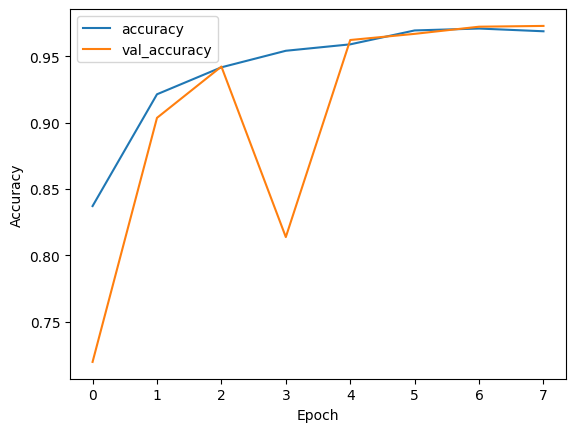

In [54]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])

plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'val_Recall')

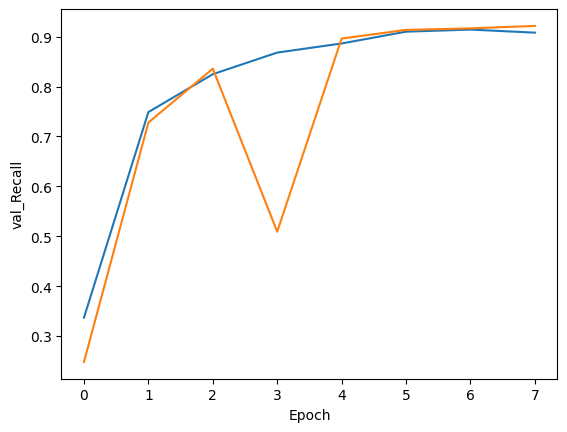

In [55]:
plt.plot(model.history.history['Recall'])
plt.plot(model.history.history['val_Recall'])
plt.xlabel('Epoch')
plt.ylabel('val_Recall')

Text(0, 0.5, 'Loss')

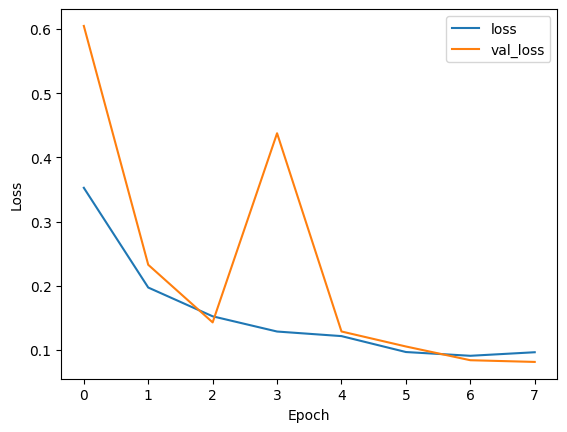

In [56]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Calculating Confusion Matrix for RestNet50 Model

In [26]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('BiLstm.h5')

In [41]:
# Function to prune weights
def prune_weights(model, threshold=0.01):
    for layer in model.layers:
        if hasattr(layer, 'kernel'):
            weights, biases = layer.get_weights()
            # Zero out weights below the threshold
            weights[np.abs(weights) < threshold] = 0
            layer.set_weights([weights, biases])

# Prune the model's weights
prune_weights(model, threshold=0.01)

# Recompile the pruned model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
        tf.keras.metrics.Recall(name='Recall'),
        tf.keras.metrics.Precision(name='Precision'),
        tf.keras.metrics.AUC(
            num_thresholds=200,
            curve="ROC",
            summation_method="interpolation",
            name="AUC",
            multi_label=True,
        ),
        F1Score(name='F1_Score')  # Add custom F1 Score metric
    ]
)

# Continue training the pruned model
model.fit(
    x=shuffle_batch_generator(batch_size=batchsize, 
                              gen_x=generate_X_shuffle(ecg_filenames, order_array), 
                              gen_y=generate_y_shuffle(y, order_array)),
    epochs=50, callbacks = callbacks,
    steps_per_epoch=len(order_array) // batchsize,
    validation_data=generate_validation_data(ecg_filenames, y, validation_indices)
)

# Save the pruned model
model.save('pruned_BiLstm.h5')

Epoch 1/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 4197s 10s/step - AUC: 0.9775 - F1_Score: 0.9738 - Precision: 0.9793 - Recall: 0.9683 - accuracy: 0.9895 - loss: 0.0330 - val_AUC: 0.9912 - val_F1_Score: 0.9704 - val_Precision: 0.9794 - val_Recall: 0.9617 - val_accuracy: 0.9882 - val_loss: 0.0348 - learning_rate: 0.0010
Epoch 2/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - AUC: 0.9877 - F1_Score: 0.9729 - Precision: 0.9774 - Recall: 0.9683 - accuracy: 0.9891 - loss: 0.0335
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
397/397 ━━━━━━━━━━━━━━━━━━━━ 4152s 10s/step - AUC: 0.9877 - F1_Score: 0.9729 - Precision: 0.9774 - Recall: 0.9684 - accuracy: 0.9891 - loss: 0.0335 - val_AUC: 0.9757 - val_F1_Score: 0.9792 - val_Precision: 0.9834 - val_Recall: 0.9751 - val_accuracy: 0.9917 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 3/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - AUC: 0.9843 - F1_Score: 0.9785 - Precision: 0.9817 - Recall: 0.9753 - accuracy: 0.9913 - loss: 0.0268


In [49]:
y_pred = model.predict(x=generate_validation_data(ecg_filenames,y,folds[0][1])[0])

266/266 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step


In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [51]:
y_pred.shape

(8482, 5)

In [52]:
y_pred_class = (y_pred > 0.5).astype(int)  # Applying a threshold


In [53]:
# Extract the ground truth labels for the validation fold
y_true = y[folds[0][1]]

In [54]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Assuming y_true and y_pred_class are already defined and correctly formatted

# # Check and convert y_true and y_pred_class to multiclass format if necessary
# if len(y_true.shape) > 1 and y_true.shape[1] > 1:
#     y_true = np.argmax(y_true, axis=1)

# if len(y_pred_class.shape) > 1 and y_pred_class.shape[1] > 1:
#     y_pred_class = np.argmax(y_pred_class, axis=1)

# # Calculate the confusion matrix
# cm = confusion_matrix(y_true, y_pred_class)

# # Normalize the confusion matrix
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# # Plot the confusion matrix with abbreviations for labels
# plt.figure(figsize=(20,15))

# # Use snomed_abbr for xticklabels and yticklabels
# sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
#             xticklabels=snomed_abbr, yticklabels=abbr)

# # Rotate x and y labels to avoid overlap
# plt.xticks(rotation=90, fontsize=8)
# plt.yticks(rotation=0, fontsize=8)

# plt.xlabel('Predicted', fontsize=12)
# plt.ylabel('True', fontsize=12)
# plt.title('Normalized Confusion Matrix', fontsize=15)

# plt.tight_layout()
# plt.show()


In [55]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Assuming y_true and y_pred_class are already defined and correctly formatted

# # Check and convert y_true and y_pred_class to multiclass format if necessary
# if len(y_true.shape) > 1 and y_true.shape[1] > 1:
#     y_true = np.argmax(y_true, axis=1)

# if len(y_pred_class.shape) > 1 and y_pred_class.shape[1] > 1:
#     y_pred_class = np.argmax(y_pred_class, axis=1)

# # Calculate the confusion matrix
# cm = confusion_matrix(y_true, y_pred_class)

# # Normalize the confusion matrix
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# # Plot the confusion matrix with abbreviations for labels
# plt.figure(figsize=(20,15))


# # Use snomed_abbr for xticklabels and yticklabels
# sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
#             xticklabels=snomed_abbr, yticklabels=snomed_abbr)

# # Rotate x and y labels to avoid overlap
# plt.xticks(rotation=90, fontsize=8)
# plt.yticks(rotation=0, fontsize=8)

# plt.xlabel('Predicted', fontsize=12)
# plt.ylabel('True', fontsize=12)
# plt.title('Normalized Confusion Matrix', fontsize=15)

# plt.tight_layout()
# plt.show()

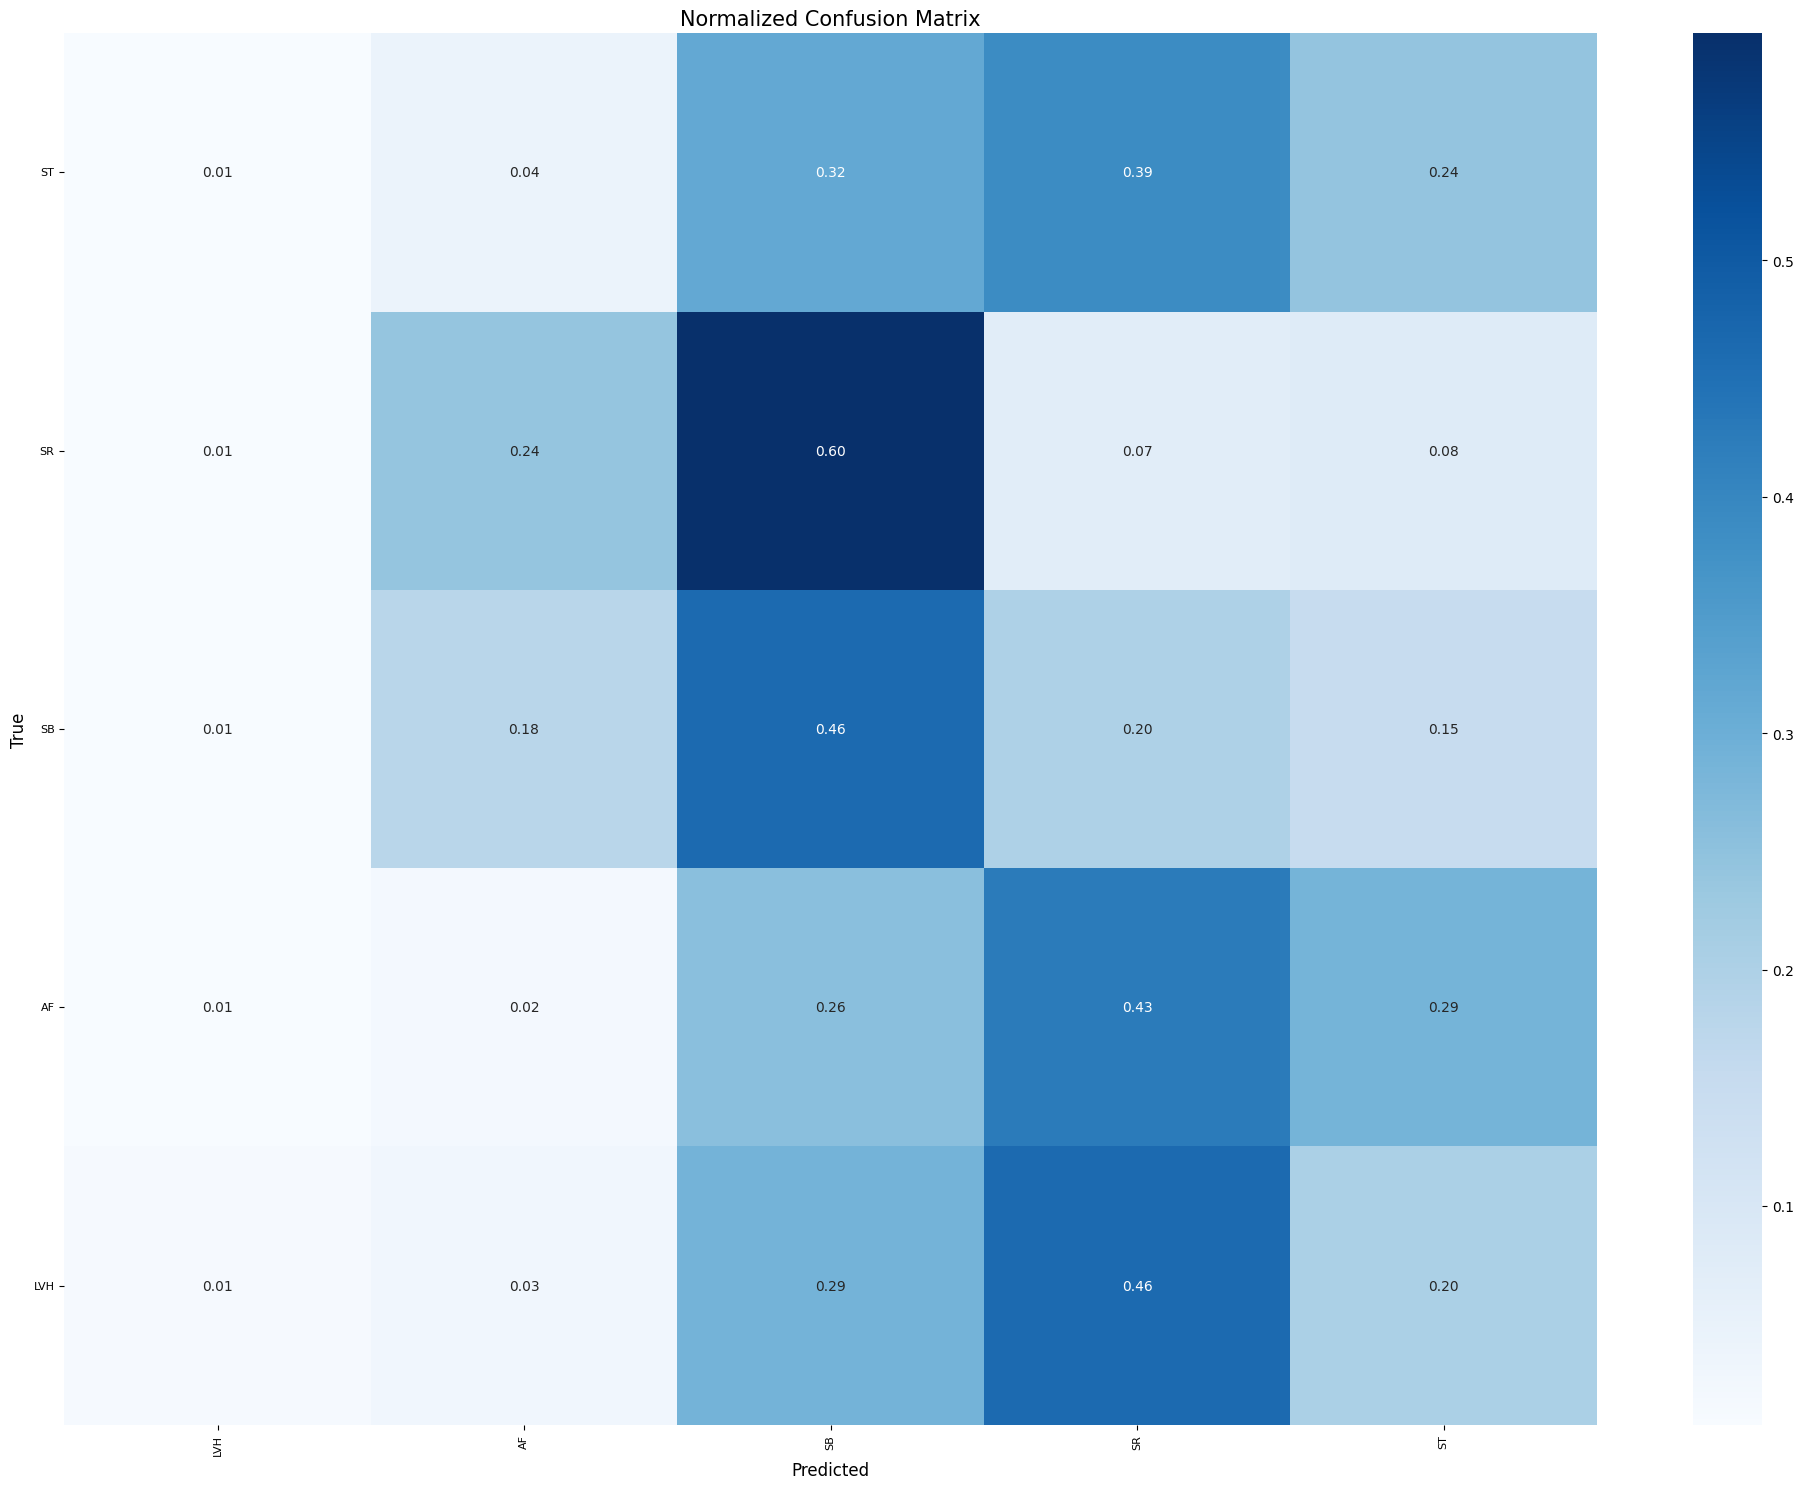

In [56]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming y_true and y_pred_class are already defined and correctly formatted

# Check and convert y_true and y_pred_class to multiclass format if necessary
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

if len(y_pred_class.shape) > 1 and y_pred_class.shape[1] > 1:
    y_pred_class = np.argmax(y_pred_class, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_class)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with abbreviations for labels
plt.figure(figsize=(20,15))

# Use snomed_abbr for xticklabels and yticklabels
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=abbr, yticklabels=abbr)

# Rotate x and y labels to avoid overlap
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Normalized Confusion Matrix', fontsize=15)

# Reverse the y-axis
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [66]:
x_test=generate_validation_data(ecg_filenames,y,folds[0][1])[0]

In [67]:
x_test

array([[[ 118,  117,  115, ...,   55,   43,   30],
        [  18,    8,    0, ...,    0,    0,    0],
        [   0,    0,   -3, ...,  -14,  -14,  -14],
        ...,
        [  -2,   -3,   -4, ...,  -10,   -9,   -7],
        [  -5,   -3,   -1, ...,   -1,   -1,   -2],
        [  -1,    0,    0, ...,    0,    0,    0]],

       [[ -78,  -83,  -87, ...,  -60,  -52,  -45],
        [ -38,  -32,  -28, ...,   -8,  -10,  -12],
        [ -14,  -16,  -18, ...,   -8,   -5,   -1],
        ...,
        [  -2,   -2,   -1, ...,    1,   -2,   -5],
        [  -8,  -12,  -15, ...,   -8,   -5,   -2],
        [   0,    0,   -1, ...,  -13,  -10,   -9]],

       [[  -2,   -3,   -3, ...,  -11,  -12,  -13],
        [ -13,  -12,  -10, ...,    2,    0,   -1],
        [  -3,   -5,   -7, ...,  -12,  -12,  -12],
        ...,
        [   5,    0,   -3, ...,  -26,  -30,  -34],
        [ -38,  -41,  -45, ...,  -44,  -42,  -40],
        [ -39,  -38,  -38, ...,  -37,  -37,  -37]],

       ...,

       [[ -52,  -53,  -5

In [46]:
y_test=generate_validation_data(ecg_filenames,y,folds[0][1])[1]

In [47]:
num_classes = y_test.shape[1]

In [48]:
predictions = model.predict(x_test)
predictions.shape

NameError: name 'x_test' is not defined

In [71]:
# Function to compute softmax error (categorical cross-entropy loss)
def compute_softmax_error(model, x_test, y_test):
    predictions = model.predict(x_test)
    loss_fn = CategoricalCrossentropy()
    softmax_error = loss_fn(y_test, predictions).numpy()
    return softmax_error

def compute_distillation_error(student_model, x_data):
    # Assuming the model has been trained
    predictions = student_model.predict(x_data)
    soft_targets = predictions 
    distillation_loss = KLDivergence()
    distillation_error = distillation_loss(soft_targets, predictions).numpy()
    return distillation_error

# Function to compute ConfWeight Error
def compute_confweight_error(model, x_data, y_data):
    predictions = model.predict(x_data)
    confidences = np.max(predictions, axis=1)
    correct_predictions = np.argmax(predictions, axis=1) == np.argmax(y_data, axis=1)
    errors = 1 - correct_predictions
    confweight_error = np.mean(errors * (1 - confidences))
    return confweight_error

In [72]:
# Compute and print Softmax Error
softmax_error = compute_softmax_error(model, x_test, y_test)
print(f"Softmax Error: {softmax_error}")

distillation_error = compute_distillation_error(model, x_test)
print(f"Distillation Error: {distillation_error}")

# Compute and print ConfWeight Error
confweight_error = compute_confweight_error(model, x_test, y_test)
print(f"ConfWeight Error: {confweight_error}")

160/160 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step
Softmax Error: 0.23740330338478088
160/160 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step
Distillation Error: 0.0
160/160 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step
ConfWeight Error: 0.01848782366773051


In [73]:
from tensorflow.keras.utils import plot_model

# Load the model
model = load_model('BiLstm.h5')

# Plot the model architecture to a file
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
